# Synthetic Data Fit

In [1]:
from drdmannturb.calibration import CalibrationProblem
from drdmannturb.data_generator import OnePointSpectraDataGenerator
from drdmannturb.shared.parameters import NNParameters, ProblemParameters, LossParameters, PhysicalParameters

import torch
import torch.nn as nn
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu" 

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

L = 0.59

Gamma = 3.9
sigma = 3.4

domain = torch.logspace(-1, 2, 20)

In [2]:
pb = CalibrationProblem(
    nn_params = NNParameters(
        activations = [nn.GELU(), nn.GELU()], 
    ),
    prob_params = ProblemParameters(nepochs=5),
    loss_params = LossParameters(),
    phys_params = PhysicalParameters(
        L=L,
        Gamma=Gamma,
        sigma=sigma,
        domain=domain
    ), 
    device=device
)

In [3]:
parameters = pb.parameters
parameters[:3] = [
    np.log(L),
    np.log(Gamma),
    np.log(sigma)
]

pb.parameters = parameters[:len(pb.parameters)]

k1_data_pts = domain
DataPoints = [(k1, 1) for k1 in k1_data_pts]

In [4]:
Data = OnePointSpectraDataGenerator(data_points=DataPoints).Data

In [5]:
pb.eval(k1_data_pts)
pb.calibrate(data=Data)


Calibrating MannNet...
torch.Size([80])
Initial loss:  0.11280374272965626

[Calibration.py -- calibrate]-> Epoch 0

loss  =  0.11280374272965626
loss  =  0.07245640995565798
loss  =  0.06635321401281861
loss  =  0.04044492440988115
loss  =  0.04040178168771631
loss  =  0.040035231819371214
loss  =  0.03973363250263798
loss  =  0.03840892141241851
loss  =  0.03840458144222995
loss  =  0.03837016421550843
loss  =  0.03835111541262268
loss  =  0.03828060762737476
loss  =  0.038254106706210454
loss  =  0.038155410099739696
loss  =  0.038119428709522424
loss  =  0.03807080546179292
loss  =  0.038013541628190865
loss  =  0.037704191592463264
loss  =  0.037666038835794814
loss  =  0.03763998024084178
loss  =  0.037543962981774606
loss  =  0.03751745685396168
loss  =  0.03734169745087619
loss  =  0.037323324407913853
loss  =  0.03721261267863437
---------------------------------



[Calibration.py -- calibrate]-> Epoch 1

loss  =  0.03721261267863437
loss  =  0.0371839602626413
loss  =  0.03

array([-4.28020994e-01,  1.84084883e+00,  1.01399312e+00,  3.58642044e-01,
        2.25301030e+00, -4.26725636e+00,  1.34083601e+00, -3.30256169e+00,
       -1.58580348e+00, -2.60089974e+00,  1.33575828e+00, -3.05188443e+00,
       -4.74542750e-01,  1.48879749e+00, -1.99953548e+00, -6.16035833e+00,
       -1.26470860e+00, -4.48194136e+00,  9.16573429e-01,  1.03010926e-01,
       -3.10590858e-01, -2.34783669e+00,  5.11032826e-02, -1.39883131e+00,
        2.92236520e+00, -2.98528377e+00, -1.90490930e+00, -5.24369181e-01,
       -1.99765295e-01, -4.70844179e-01,  3.15684155e-01, -2.23994544e-01,
        2.45735513e+00, -5.23849194e-01,  8.24073630e-02, -8.82949987e-01,
       -5.13309678e+00,  1.94167790e+00, -2.11020873e-01, -1.23265038e+00,
       -3.25379869e+00, -4.61891478e-02, -4.23270570e+00, -4.07137582e+00,
        2.91886261e+00,  2.17742775e+00, -3.83455791e+00,  3.16061256e+00,
        1.56333411e+00,  3.82298806e-01,  1.79644906e+00,  2.11107151e-01,
       -3.55645795e-05,  

k1.size: torch.Size([20])   self.kF_data_vals: torch.Size([80])


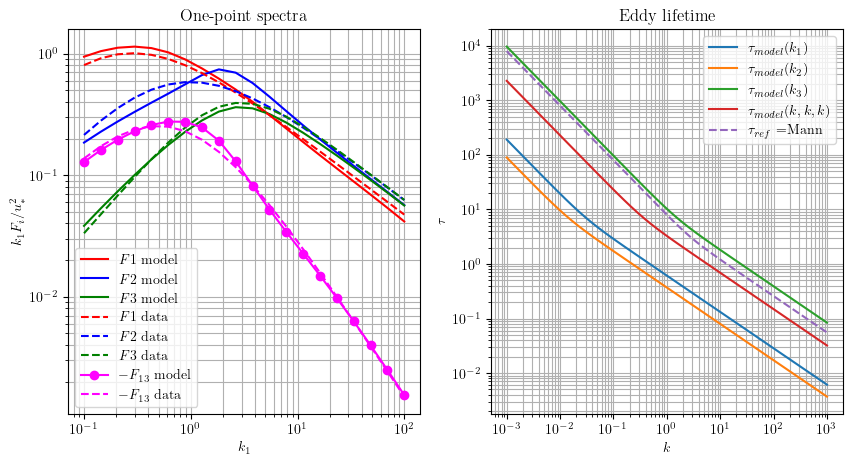

In [6]:
pb.plot(plt_dynamic=False)

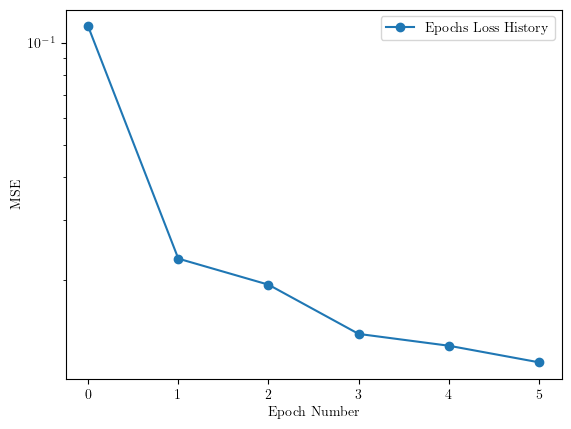

In [7]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot( pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend()
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show()


## Save Model with Problem Metadata

In [8]:
pb.save_model('../results/')

## Loading Model and Problem Metadata

In [9]:
import pickle
path_to_parameters = "../results/EddyLifetimeType.CUSTOMMLP_DataType.KAIMAL.pkl"

with open(path_to_parameters, 'rb') as file: 
    nn_params, prob_params, loss_params, phys_params, model_params, loss_history_total, loss_history_epochs = pickle.load(file)

### Recovering Old Model Configuration and Old Parameters

In [14]:
pb_new = CalibrationProblem(nn_params=nn_params, prob_params=prob_params, loss_params=loss_params, phys_params=phys_params, device=device)

pb_new.parameters = model_params

assert (pb.parameters == pb_new.parameters).all()